In [ ]:
# Follow the tutorial here: https://langchain-ai.github.io/langgraph/tutorials/get-started/1-build-basic-chatbot/#prerequisites

In [1]:
# Install the necessary packages
%pip install -q -U langgraph langsmith

Note: you may need to restart the kernel to use updated packages.


In [2]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages

class State(TypedDict):
    # Messages have the type list. The add_messages fucntion
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [3]:
# Add a node with google's gemini model
%pip install -q -U "langchain[google-genai]"

Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
from dotenv import load_dotenv
from langchain.chat_models import init_chat_model

load_dotenv()

llm = init_chat_model(os.getenv("LANGCHAIN_GOOGLE_LLM_MODEL"))


In [8]:
def chatbot(state:State):
    return {"messages": [llm.invoke(state["messages"])]}

# The first argument is the unique node name
# The second sargumetn is the fucntion or object that willl be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [9]:
# Add en entry point
graph_builder.add_edge(START, "chatbot")

In [10]:
# Compile the graph
graph = graph_builder.compile()

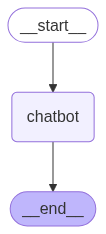

In [11]:
# Visualize the graph
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error visualizing graph: {e}")

In [13]:
# Run the chatbot
def stream_graph_update(user_input:str):
    for event in graph.stream({"messages":[{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["q", "quit", "exit"]:
            print("Exiting...")
            break
        stream_graph_update(user_input)
    except Exception as e:
        # Fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_update(user_input)
        break
    except EOFError:
        print("Exiting...")
        break


Assistant: Ah, the dream of taming a dragon! Unfortunately, in the real world, dragons are mythical creatures, so you can't tame one. But, since you're asking, let's explore some fun, imaginative scenarios where you might have a *chance* to tame a dragon:

**In the Realm of Fantasy:**

*   **Your Favorite Fantasy Novel or Movie:** If you're thinking of a specific fictional world like *How to Train Your Dragon*, *Eragon*, or *Game of Thrones*, the rules for taming dragons are set by the author. You'd need to understand that world's lore.
*   **A High-Fantasy Setting:** In a generic high-fantasy setting, you'd likely need a combination of:
    *   **A Strong Bond:** Dragons are often intelligent and proud creatures. Earning their trust is paramount. This might involve acts of bravery, kindness, or understanding.
    *   **Magical Ability:** Some settings require magical aptitude to communicate with or control dragons.
    *   **Dragon-Specific Knowledge:** Understanding dragon behavior, 

/home/yair/learning/langchain-testing-ground/.venv/lib/python3.12/site-packages/langchain_google_genai/chat_models.py:1568: UserWarning: HumanMessage with empty content was removed to prevent API error
  warnings.warn(


User: What do you know about LangGraph?
Assistant: LangGraph is a framework developed by LangChain for building stateful, multi-actor applications using Large Language Models (LLMs). It allows you to create conversational AI agents that can reason, plan, and take actions in a more structured and reliable way than traditional LLM chains.

Here's a breakdown of what I know about LangGraph:

**Key Concepts and Features:**

* **Stateful Graphs:** LangGraph introduces the concept of a stateful graph, where the application's state is explicitly managed and updated as the graph executes. This allows for memory and context to be maintained throughout the application's lifecycle.
* **Nodes:** Nodes are the fundamental building blocks of a LangGraph. They represent the different actors or steps in your application. Nodes can be:
    * **LLM Chains:**  Integrate LLMs for tasks like generating text, answering questions, or translating languages.
    * **Tools:**  Connect to external tools like sea

In [14]:
# Lets implement a search agent now
# Install tavily if not already installed
%pip install -q -U langchain-tavily

Note: you may need to restart the kernel to use updated packages.


In [17]:
import os
from dotenv import load_dotenv
from langchain_tavily import TavilySearch

load_dotenv()

# create a tool
tavily_search_tool = TavilySearch(max_results=2)
tools = [tavily_search_tool]
tavily_search_tool.invoke("What is the current weather in Tokyo?")

{'query': 'What is the current weather in Tokyo?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'Weather in Tokyo',
   'url': 'https://www.weatherapi.com/',
   'content': "{'location': {'name': 'Tokyo', 'region': 'Tokyo', 'country': 'Japan', 'lat': 35.6895, 'lon': 139.6917, 'tz_id': 'Asia/Tokyo', 'localtime_epoch': 1749523520, 'localtime': '2025-06-10 11:45'}, 'current': {'last_updated_epoch': 1749523500, 'last_updated': '2025-06-10 11:45', 'temp_c': 21.1, 'temp_f': 70.0, 'is_day': 1, 'condition': {'text': 'Light rain', 'icon': '//cdn.weatherapi.com/weather/64x64/day/296.png', 'code': 1183}, 'wind_mph': 2.7, 'wind_kph': 4.3, 'wind_degree': 14, 'wind_dir': 'NNE', 'pressure_mb': 1011.0, 'pressure_in': 29.85, 'precip_mm': 0.04, 'precip_in': 0.0, 'humidity': 88, 'cloud': 75, 'feelslike_c': 21.1, 'feelslike_f': 70.0, 'windchill_c': 21.0, 'windchill_f': 69.8, 'heatindex_c': 21.0, 'heatindex_f': 69.8, 'dewpoint_c': 18.6, 'dewpoint_f': 65.4, 'vis_km': 7.

In [18]:
# Lets update our stategraph
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

llm_with_tools = llm.bind_tools(tools)

def chatbot(state:State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

In [20]:
# Create a function to run the tools
import json
from langchain_core.messages import ToolMessage

class BasicToolNode:
    """ A node that runs the tools requested in the last AI Message."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}
        
    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No messages found in the input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(tool_call["args"])
            outputs.append(ToolMessage(
                content=json.dumps(tool_result),
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            ))
        return {"messages": outputs}

tool_node = BasicToolNode(tools=[tavily_search_tool])
graph_builder.add_node("tools", tool_node)

In [22]:
def route_tools(state:State):
    """
    Use in the conditional_edge to route to the ToolNode if the last message has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END

# The 'tools_condtion' functino returns "tools" if the cahtbots asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interperet the condtion's outputs as a specific node.
    # It defaults to the identity function but if you want to use a node named something else
    # apart from tools, you can update the value of the dictionary to something else.
    # e.g. "tools" : "my_tools"
    {"tools": "tools", END: END},
)

# Any time a tool is called, we return to the chatbot to decide the next step.
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()
        

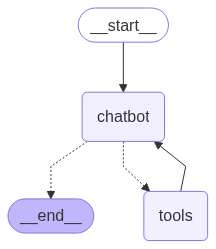

In [23]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error visualizing graph: {e}")

In [24]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: 
Assistant: {"query": "when was pepsi black created", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "How Business Has Undermined Racism: The Pepsi Story", "url": "https://www.psychologytoday.com/intl/blog/fully-human/201902/how-business-has-undermined-racism-the-pepsi-story", "content": "The effects were not immediate, but during the 1950s Pepsi's sales increased dramatically, eventually outselling Coke in the black community by a margin of three to one.", "score": 0.365344, "raw_content": null}, {"title": "Pepsi Max - Wikipedia", "url": "https://en.wikipedia.org/wiki/Pepsi_Max", "content": "Pepsi Max (also known as Pepsi Black in some countries and Pepsi Zero in Poland and Portugal) is a low-calorie, sugar-free cola, marketed by PepsiCo as an alternative to Pepsi and Diet Pepsi, except for Norway, where it is the main Pepsi flavor.[citation needed] Pepsi Max is available primarily in Asian, European and Australia/New Zealand markets. Recen

/home/yair/learning/langchain-testing-ground/.venv/lib/python3.12/site-packages/langchain_google_genai/chat_models.py:1568: UserWarning: HumanMessage with empty content was removed to prevent API error
  warnings.warn(


User: What do you know about LangGraph?
Assistant: 
Assistant: {"query": "LangGraph", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.ibm.com/think/topics/langgraph", "title": "What is LangGraph? - IBM", "content": "LangGraph, created by [LangChain](https://www.ibm.com/think/topics/langchain), is an open source AI agent framework designed to build, deploy and manage complex generative AI agent workflows. It provides a set of tools and libraries that enable users to create, run and optimize [large language models](https://www.ibm.com/think/topics/large-language-models) (LLMs) in a scalable and efficient manner. At its core, LangGraph uses the power of graph-based architectures to model and manage the [...] By using a graph-based architecture, LangGraph enables users to scale artificial intelligence workflows without slowing down or sacrificing efficiency. LangGraph uses enhanced decision-making by modeling complex relationships between nodes, 

In [25]:
# Using prebuilts
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearch(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

In [26]:
# Create a memory saver checkpointer
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [29]:
# Compile the graph
graph = graph_builder.compile(checkpointer=memory)

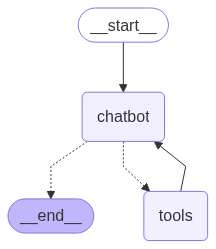

In [30]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error visualizing graph: {e}")

In [31]:
# Thread = key for this conversation
config = {"configurable": {"thread_id": "1"}}

user_input = "What whale is the largest?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config=config,
    stream_mode="values",
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What whale is the largest?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (38e162ce-1aa6-449f-a664-d71f97067ee5)
 Call ID: 38e162ce-1aa6-449f-a664-d71f97067ee5
  Args:
    query: largest whale
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "largest whale", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "Blue whale - Wikipedia", "url": "https://en.wikipedia.org/wiki/Blue_whale", "content": "m. musculusLinnaeus, 1758 Blue whale range (in blue) Synonyms Balaena musculusLinnaeus, 1758Balaenoptera gibbarScoresby1820Pterobalaena gigasVan Beneden1861Physalus latirostrisFlower1864Sibbaldius borealisGray1866Flowerius gigasLilljeborg1867Sibbaldius sulfureusCope1869Balaenoptera sibbaldiiSars1875 The blue whale (Balaenoptera musculus) is a 